In [145]:
with open('data.txt','r') as f:
    raw_text = f.read()

In [146]:
print(raw_text[100:200])

in the United States and
most other parts of the world at no cost and with almost no restrictions
wh


In [147]:
print(f"Total Number of characters: {len(raw_text)}")

Total Number of characters: 92874


## Word Tokenization

In [148]:
import re
vocab = list(set([item.strip() for item in re.split(r'([,.”?/()\'’]|\s)',raw_text) if item.strip()]))
vocab[:20]

['dang',
 'that;',
 ']',
 'gauded',
 'rest',
 'sense',
 'they',
 'aces',
 'SIMS',
 '“You--you',
 'anxious-like',
 'whatsoever',
 'yelpin',
 'stole',
 '“Two-bits',
 'sleeve',
 'Chamber',
 'Perkins',
 'see',
 'lemon']

In [149]:
## Creating token IDs
idx2str = {idx:token for idx,token in enumerate(vocab)}
idx2str[len(idx2str)] = "<UNK>"
idx2str[len(idx2str)] = "<|eot|>"
str2idx = {token:idx for idx,token in idx2str.items()}

print(f"Number of tokens::{len(idx2str)}")

Number of tokens::3361


In [150]:
## Creating a custom tokenizer class

class CustomTokenizerV1():
    def __init__(self, vocab, special_tokens = ["<|eot|>","<|cls|>","<|sep|>"]):
        self.idx2str = {idx:token for idx,token in enumerate(vocab)}
        ## adding special tokens
        self.idx2str[len(self.idx2str)] = "<|unk|>"
        for tok in special_tokens:
            self.idx2str[len(self.idx2str)] = tok
        self.str2idx = {token:idx for idx,token in self.idx2str.items()}
        assert len(self.idx2str) == len(self.str2idx)
        print(f"Total Number of tokens::{len(self.idx2str)}", end = "\n\n")
        print(f"-"*10 + " "+ "Special Tokens" + "-"*10, end = '\n\n')
        for tok in special_tokens:
            print(f"Token ID for {tok}::{self.str2idx[tok]}")

    def encode(self,seq):
        preprocessed = [item.strip() for item in re.split(r'([,.”?/()\'’]|\s)',seq) if item.strip()]
        tokenized = [self.str2idx.get(tok,self.str2idx.get("<|unk|>")) for tok in preprocessed]
        return tokenized

    def decode(self, tok_seq):
        text = ' '.join([self.idx2str.get(item) for item in tok_seq])
        text = re.sub(r'([,.”?/()\'’]|\s)',r'\1',text)
        return text


In [151]:
tokenizer = CustomTokenizerV1(vocab)
seq = "How are you doing charles?"
ids = tokenizer.encode(seq)
tokenizer.decode(ids)



Total Number of tokens::3363

---------- Special Tokens----------

Token ID for <|eot|>::3360
Token ID for <|cls|>::3361
Token ID for <|sep|>::3362


'How are you doing <|unk|> ?'

In [152]:
## using sub-word tokenization from tiktoken (Byte Pair Encoding)
import tiktoken
tokenizer_subword = tiktoken.get_encoding("gpt2")
seq = "How are you doing charles?<|endoftext|>"
ids = tokenizer_subword.encode(seq, allowed_special={"<|endoftext|>"})
for id_ in ids:
    print(tokenizer_subword.decode([id_]))


How
 are
 you
 doing
 char
les
?
<|endoftext|>


## BPE Encoding (Sub-Word Tokenization)

In [153]:

with open('data.txt','r') as f:
    raw_text = f.read()

encoded = tokenizer_subword.encode(raw_text)
print(f"Total number of tokens post encoding::{len(encoded)}")

Total number of tokens post encoding::29698


In [154]:
context_size = 5
X = encoded[:context_size]
y = encoded[1:context_size+1]
print(f"train samples::{X}")
print(f"test samples::{y}")

train samples::[464, 4935, 20336, 46566, 286]
test samples::[4935, 20336, 46566, 286, 1649]


## Creating DataLoader with Sub-Word tokenization

In [155]:
from typing import Any
from torch.utils.data import Dataset, DataLoader
from torch import tensor, arange

class GPTDatasetV1(Dataset):

    def __init__(self, txt, context_size, stride, tokenizer):
        self.input_ids = []
        self.output_ids = []
        ## tokenizing the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        ## looping over the sequences
        for i in range(0, len(token_ids) - context_size, stride):
            input_chunk = token_ids[i:i+context_size]
            target_chunk = token_ids[i+1:i+context_size+1]
            self.input_ids.append(tensor(input_chunk))
            self.output_ids.append(tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {"x":self.input_ids[idx],
                "y":self.output_ids[idx]}


def get_dataloader(txt, batch_size = 4, context_size = 1024, stride = 512,
                   shuffle = True, drop_last = True, num_workers = 0):
    '''Creates a dataloader object'''
    ## loading the sub-word tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    ## creating dataset oject
    dataset = GPTDatasetV1(txt, tokenizer=tokenizer,
                           context_size=context_size, stride=stride)
    ## creating the dataloader object
    dataloader = DataLoader(dataset,batch_size=batch_size,
                            drop_last=drop_last,
                            num_workers=num_workers,
                            shuffle = shuffle)
    return dataloader

In [156]:
loader = get_dataloader(raw_text, batch_size=8, 
                        context_size=1024, stride=512)


In [157]:
for batch in loader:
    print("Input Tensor",batch["x"],f"Input Tensor Shape::{batch['x'].shape}",sep = "\n")
    print("--"*10)
    print("Output Tensor",batch["y"],f"Output Tensor Shape::{batch['y'].shape}",sep = "\n")
    break

Input Tensor
tensor([[10213,   351,  7322,  ...,  8151,   198,  9509],
        [  314,   447,   247,  ...,   447,   247,    82],
        [   11,   611,   484,  ...,   847,    82, 22752],
        ...,
        [ 9353,   286,   465,  ...,   259,   447,   247],
        [  326, 20950,    11,  ...,  1561,   259,   447],
        [ 2088,   287,    13,  ...,  1370,    13,   447]])
Input Tensor Shape::torch.Size([8, 1024])
--------------------
Output Tensor
tensor([[  351,  7322,   352,  ...,   198,  9509,  4565],
        [  447,   247,    76,  ...,   247,    82,   331],
        [  611,   484,  2492,  ...,    82, 22752,   263],
        ...,
        [  286,   465,  2832,  ...,   447,   247,    30],
        [20950,    11,   447,  ...,   259,   447,   247],
        [  287,    13,   314,  ...,    13,   447,   251]])
Output Tensor Shape::torch.Size([8, 1024])


## Token Embedding

In [158]:

from torch.nn import Embedding, LSTM, RNN
from torch.optim import Adam, RMSprop, SGD
vocab_size = tokenizer_subword.n_vocab
embedding_dim = 768

embedding_layer = Embedding(vocab_size, embedding_dim)
embedding_layer.weight.shape

torch.Size([50257, 768])

In [159]:
embedding_layer(tensor([[1,2,3, 9 ,8 ,22]])).shape

torch.Size([1, 6, 768])

In [160]:
embedding_layer(batch['x']).shape

torch.Size([8, 1024, 768])

## Positional Embedding/Encoding

In [161]:
## Positional Embeddings (Absolute Positional Encoding)
context_size = 1024
embedding_dim = 768
pos_embedding_layer = Embedding(context_size, embedding_dim)

In [162]:
pos_embedding_layer(arange(context_size)).shape

torch.Size([1024, 768])

In [163]:
embeddings = embedding_layer(batch['x'])
print(f"Embedding Shape::{embeddings.shape}")
pos_embeddings = pos_embedding_layer(arange(context_size))
print(f"Positional Embedding::{pos_embeddings.shape}")
final_input_embedding = embeddings + pos_embeddings
print(f"Embeddings + Positional Embedding::{final_input_embedding.shape}") # this will be the input to the self attention layer

Embedding Shape::torch.Size([8, 1024, 768])
Positional Embedding::torch.Size([1024, 768])
Embeddings + Positional Embedding::torch.Size([8, 1024, 768])


## Attention Mechanisms

### 1. Simplified Attention Mechanism **(No Trainable Weights)**
- Converting **Embedding Vectors** to **Context Vectors**

In [164]:
text = "I see skies of green, red roses too"
token_ids = tokenizer_subword.encode(text)

In [165]:
print(f"Token IDs::{token_ids}")
print(f"Decoded Token IDs::{tokenizer_subword.decode(token_ids)}")

Token IDs::[40, 766, 24091, 286, 4077, 11, 2266, 42152, 1165]
Decoded Token IDs::I see skies of green, red roses too


In [166]:
## Creating an embedding layer
VOCAB_SIZE = tokenizer_subword.n_vocab # Vocab Size of the sub-word tokenizer
EMBEDDING_SIZE = 3 # For Simplicity embedding each token into a 3-Dimensional Space
embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_SIZE)

In [167]:
## Creating Embedding of our tokens
embeddings = embedding_layer(tensor(token_ids))
embeddings.shape

torch.Size([9, 3])

In [168]:
embeddings = embeddings.detach().numpy().reshape(-1,3)
for emb, tok in zip(embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb}")



I --> [-0.6472748  0.8377666  1.2140747]
see --> [ 1.1404505  0.428995  -0.677243 ]
skies --> [ 1.250111    0.22392692 -0.02307102]
of --> [-0.6941792 -0.595996   1.1745043]
green --> [-0.5237728   0.80277544  0.690119  ]
, --> [ 1.8169491   0.43056518 -0.2621332 ]
red --> [ 1.6252327   0.8769036  -0.35437042]
roses --> [-0.55545956 -0.3580691  -1.2126197 ]
too --> [-1.2315537 -1.0304981  1.9863523]


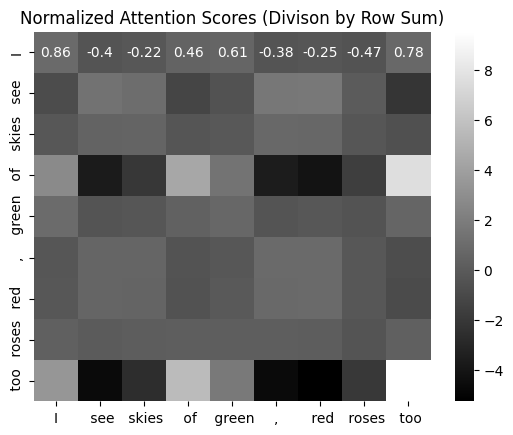

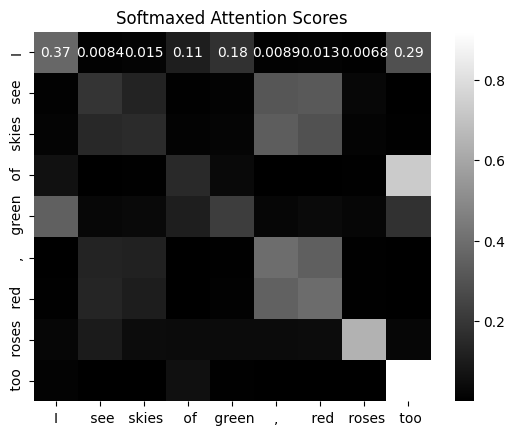

In [169]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def softmax(mat):
    '''Softmax as implemented in pytorch'''
    num_ =  np.exp(mat-np.max(mat, axis=1, keepdims=True))
    denom_ = np.sum(num_, axis=1, keepdims=True)
    return num_/denom_


labels = [tokenizer_subword.decode([i]) for i in token_ids]
attention_scores = embeddings @ embeddings.T
# Normalizing the attention scores by dividing by sum of the corresponding rows
normalized_attention_scores = attention_scores/np.sum(attention_scores, axis=1, keepdims=True)
## Plotting the HeatMap for the Normalized Attention Scores
sns.heatmap(normalized_attention_scores, annot=True, cmap='gray',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Normalized Attention Scores (Divison by Row Sum)")
plt.show();

softmaxed_attention_scores = softmax(attention_scores)
sns.heatmap(softmaxed_attention_scores, annot=True, cmap='gray',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Softmaxed Attention Scores")
plt.show();

In [170]:
context_embeddings = softmaxed_attention_scores @ embeddings
for emb, tok in zip(context_embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb}")

I --> [-0.70500374  0.10888268  1.2571155 ]
see --> [ 1.4242388   0.5272965  -0.33349913]
skies --> [ 1.4086171   0.5118948  -0.25622582]
of --> [-1.0505167  -0.76061726  1.7198049 ]
green --> [-0.4720013   0.27069643  0.9893231 ]
, --> [ 1.5581661   0.555983   -0.30891564]
red --> [ 1.5427735   0.58163935 -0.31538153]
roses --> [-0.13854852 -0.1191417  -0.7169856 ]
too --> [-1.1864907  -0.96901417  1.9187    ]


#### Same stuff but using pytorch

In [171]:
import torch
attn_scores = embeddings @ embeddings.T
attn_weights = torch.softmax(tensor(attn_scores), dim = -1)
context_embeddings = attn_weights @ embeddings
for emb, tok in zip(context_embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb.detach().numpy()}")

I --> [-0.70500374  0.10888268  1.2571155 ]
see --> [ 1.4242387  0.5272965 -0.3334991]
skies --> [ 1.4086171  0.5118948 -0.2562258]
of --> [-1.0505167  -0.76061726  1.7198049 ]
green --> [-0.47200134  0.27069643  0.9893231 ]
, --> [ 1.5581663   0.55598307 -0.30891564]
red --> [ 1.5427731  0.5816393 -0.3153815]
roses --> [-0.13854854 -0.11914169 -0.7169856 ]
too --> [-1.1864907 -0.9690142  1.9187001]


#### We observe our calculations give us similar results

#### Why the need for Trainable Weights?

### 2. Self Attention Mechanism **(With Trainable Weights)**
- Converting **Embedding Vectors** to **Context Vectors**
- Creating *Query*, *Key* and *Value* matrices **(Trainable Weights)**

In [172]:
torch.manual_seed(123)
d_in = EMBEDDING_SIZE
d_out = 2
w_Q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Query Weight Matrix
w_K = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Key Weight Matrix
w_V = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Value Weight Matrix

In [173]:
embeddings_tensors = tensor(embeddings)

In [174]:
query = embeddings_tensors @ w_Q
key = embeddings_tensors @ w_K
value = embeddings_tensors @ w_V
query

tensor([[ 0.1090,  1.2945],
        [ 0.3956,  0.2977],
        [ 0.4248,  0.7800],
        [-0.2687,  0.2488],
        [ 0.0980,  0.8802],
        [ 0.6270,  1.0079],
        [ 0.6757,  1.1363],
        [-0.3443, -1.5842],
        [-0.4771,  0.3755]])

#### Can also be done in a different way

In [175]:
## concating query, key and value weights horizontally
q_k_v = torch.concat([w_Q,w_K,w_V], dim = -1)
print(f"Inputs shape::{embeddings_tensors.shape}")
print(f"q_k_v shape::{q_k_v.shape}")
outputs = embeddings_tensors@q_k_v
print(f"Outputs shape::{outputs.shape}")

Inputs shape::torch.Size([9, 3])
q_k_v shape::torch.Size([3, 6])
Outputs shape::torch.Size([9, 6])


In [176]:
query_new, key_new, value_new = torch.hsplit(outputs,3)
query_new==query

tensor([[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False]])

In [177]:
attn_scores = query_new @ key_new.T
scaled_attn_scores = attn_scores/torch.math.sqrt(w_K.shape[-1]) ## scaled attention scores
attn_weights = torch.softmax(scaled_attn_scores, dim = -1)

context_vectors = attn_weights @ value_new

print("Context Vectors", end = "\n")
print("--"*10, end='\n\n')
for emb, tok in zip(context_vectors,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb.detach().numpy()}")

Context Vectors
--------------------

I --> [0.1912074 0.6567588]
see --> [0.13980873 0.47482994]
skies --> [0.16891165 0.5813366 ]
of --> [0.11982574 0.39515424]
green --> [0.16885857 0.5793228 ]
, --> [0.1841225 0.6353627]
red --> [0.1912325  0.65968496]
roses --> [-0.07364208 -0.3796622 ]
too --> [0.12353887 0.4082601 ]


#### Why we divide the attention scores by sqrt(key dimension)?
1. **Stability in Learning**

### Causal Attention Layer

In [178]:
CONTEXT_SIZE = 5
inp_text = "Hello How are you?"
embedding_layer = Embedding(tokenizer_subword.n_vocab, 768)
pos_embedding_layer = Embedding(CONTEXT_SIZE, 768)
inp_tok =tokenizer_subword.encode(inp_text)
embeddings = embedding_layer(tensor([inp_tok]))
pos_emb = pos_embedding_layer(torch.arange(tensor(embeddings.shape[1])))
inp_embedding = embeddings + pos_emb


In [179]:
class CausalAttention(torch.nn.Module):
    def __init__(self, d_in, d_out,context_length,
                 dropout = 0, q_k_v_bias = False,
                 causal_mask = True):
        super().__init__()
        self.W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.dropout = torch.nn.Dropout(dropout)
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        # batch, seq_len, d_in = x.shape
        q_k_v =  torch.concat([self.W_query,self.W_key,self.W_value],dim = -1)
        # print(f"q_k_v shape: {q_k_v.shape}")
        combined_transform = x @ q_k_v
        # print(f"combined_transform shape: {combined_transform.shape}")
        query, key, value = torch.split(combined_transform,self.W_key.shape[-1], dim=2)
        attn_weights = query @ key.transpose(1,2) # (batch X seq_len X seq_len)
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool(),-torch.inf)
        scaled_attn_weights = attn_weights/key.shape[-1]**0.5
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))
        return {"context_vectors": attn_scores @ value,
                "attn_scores": attn_scores} # context rich vectors (batch X seq_len X embedding_dim)


In [180]:
# inp_embedding = torch.concat([inp_embedding]*5, dim = 0)
c_attn = CausalAttention(*(768,768,5), causal_mask=True)
# c_attn(inp_embedding)

In [181]:
for param in c_attn.parameters():
    print(param.shape)

torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])


In [182]:
c_attn(inp_embedding)

{'context_vectors': tensor([[[  2.3038,  -6.3534,   0.2914,  ...,  -6.2244,   9.5452,  -8.3201],
          [  2.3038,  -6.3534,   0.2914,  ...,  -6.2244,   9.5452,  -8.3201],
          [ 37.6857,  25.8231,  17.3346,  ...,  21.4372,  28.7299,  36.8135],
          [ 37.6857,  25.8231,  17.3346,  ...,  21.4372,  28.7299,  36.8135],
          [-34.3452, -44.6836, -41.2677,  ..., -44.9336, -21.9690, -32.7346]]],
        grad_fn=<UnsafeViewBackward0>),
 'attn_scores': tensor([[[1., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)}

### Muti Head Attention

In [201]:
## applies heads sequentially
class MultiHeadAttentionWrapper(torch.nn.Module):
    def __init__(self, d_in, d_out,context_length, num_heads, dropout = 0.0, q_k_v_bias = False):
        super().__init__()
        self.out_layer = torch.nn.Parameter(torch.rand(num_heads * d_out, d_out))
        self.heads = torch.nn.ModuleList([CausalAttention(d_in, d_out,context_length) for _ in range(num_heads)])
    def forward(self, x):
        concated_context_vecs = torch.concat([head(x)['context_vectors'] for head in self.heads], dim=-1)
        return concated_context_vecs @ self.out_layer


In [184]:
multi_attn = MultiHeadAttentionWrapper(768,3,5,10, dropout=0.5)

In [185]:
out_ = multi_attn(inp_embedding)
out_.shape

torch.Size([1, 5, 30])

#### Improving the MultiHead Attention By implementing the heads parallely

In [210]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads,dropout = 0.0, causal_mask = True):
        super().__init__()
        self.num_heads = num_heads
        self.d_out = d_out
        self.W_query = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.dropout = torch.nn.Dropout(dropout)
        self.out_project = torch.nn.Parameter(torch.rand(num_heads *d_out, d_out, dtype=torch.float32))
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        batch_size, seq_len, d_in = x.shape
        # q_k_v =  torch.concat([self.W_query,self.W_key,self.W_value],dim = -1)
        queries = x @ self.W_query
        keys = x @ self.W_key
        values = x @ self.W_value

        # Reshape for multi-head attention
        queries = queries.view(batch_size, seq_len, self.num_heads, self.d_out)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.d_out)
        values = values.view(batch_size, seq_len, self.num_heads, self.d_out)

        # Transpose the shapes (Grouping with respect to number of heads)
        queries = queries.transpose(1,2)# (batch X num_heads X seq_len X d_out)
        keys = keys.transpose(1,2)# (batch X num_heads X seq_len X d_out)
        values = values.transpose(1,2)# (batch X num_heads X seq_len X d_out)

        # Calculating Attention Scores
        attn_weights = queries @ keys.transpose(2,3) # (batch X num_heads X seq_len X seq_len)

        # Adding the Causal Mask
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool(),-torch.inf)# (batch X num_heads X seq_len X seq_len)

        # Scaling and Softmax the atten scores
        scaled_attn_weights = attn_weights/keys.shape[-1]**0.5# (batch X num_heads X seq_len X seq_len)
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))# (batch X num_heads X seq_len X seq_len)
        print(f"Attention Shape::{attn_scores.shape}")
        print(f"Max val in attn score matrix:: {attn_scores.max().detach().numpy()}")
        context_vectors = (attn_scores @ values).transpose(1,2)# (batch X seq_len X num_heads X d_out)
        concated_context_vectors = context_vectors.contiguous().view(batch_size,seq_len,-1)# (batch X seq_len X num_heads * d_out)
        context_vectors = concated_context_vectors @ self.out_project# (batch X seq_len X d_out)
        return {"context_vectors": context_vectors,
                "attn_scores": attn_scores} # context vectors (batch X seq_len X embedding_dim)
                                            # attn_scores (batch X num_heads X seq_len X seq_len)



In [211]:
inp_embedding.shape

torch.Size([1, 5, 768])

In [212]:
# making batch size = 5
inp_embedding_new = torch.concat([inp_embedding]*10, dim =0)
inp_embedding_new += torch.rand(size = (inp_embedding_new.shape)) # making values in each batch different
inp_embedding_new.shape

torch.Size([10, 5, 768])

In [215]:
multi_attn = MultiHeadAttention(d_in=768,
                                d_out = 751,
                                num_heads=2,
                                context_length=5,
                                dropout=0.0)

In [216]:
multi_attn(inp_embedding_new)['context_vectors'].shape

Attention Shape::torch.Size([10, 2, 5, 5])
Max val in attn score matrix:: 1.0


torch.Size([10, 5, 751])

In [191]:
attn_scores = multi_attn(inp_embedding_new)['attn_scores']

Attention Shape::torch.Size([10, 2, 5, 5])


In [192]:
(attn_scores.shape)

torch.Size([10, 2, 5, 5])

In [ ]:
batch_size, num_heads, _, _= attn_scores.shape
for batch in range(batch_size):
    for head in range(num_heads):
        sns.heatmap(attn_scores[batch, head,:,:].detach())
        plt.title(f"BATCH::{batch+1} | HEAD::{head + 1}")
        plt.show()

### GPT 2 Model

In [271]:
# configuration dictionary
GPT2_CONFIG = {
                "vocab_size":50257,
                "context_len":1024,
                "embedding_dim":768,
                "dropout_rate":0.0,
                "n_layers":12,
                "n_heads":12,
                "q_k_v_bias":False
              }

In [282]:
class DummyGPT2(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.emb_layer = torch.nn.Embedding(self.config.get('vocab_size'),
                                            self.config.get('embedding_dim'))
        self.pos_enc_layer = torch.nn.Embedding(self.config.get("context_len"),
                                                self.config.get("embedding_dim"))
        self.drop_emb_layer = torch.nn.Dropout(self.config.get('dropout_rate'))

        # Transformer Blocks
        self.trf_blocks = torch.nn.Sequential(*[DummyTransformerlock(GPT2_CONFIG) \
                                                for _ in range(self.config.get("n_layers"))])
        # LayerNorm
        self.final_norm = DummyLayerNorm(GPT2_CONFIG)

        # output head
        self.out_head = torch.nn.Linear(self.config.get("embedding_dim"),
                                        self.config.get("vocab_size"))

    def forward(self, inp_):
        batch_size, seq_len = inp_.shape
        tok_emb = self.emb_layer(inp_)
        pos_emb = self.pos_enc_layer(torch.arange(seq_len, device = inp_.device))
        inp_emb = tok_emb + pos_emb
        inp_emb = self.drop_emb_layer(inp_emb)
        x = self.trf_blocks(inp_emb)
        x = self.final_norm(x)
        logits = self.out_head(x) # (batch_size X seq_len X vocab_size)
        return logits



class DummyTransformerlock(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        pass
    def forward(self, x):
        ## TODO:: add code
        return x

class DummyLayerNorm(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        pass
    def forward(self, x):
        return x


In [283]:
gpt_model = DummyGPT2(GPT2_CONFIG)

In [284]:
gpt_model

DummyGPT2(
  (emb_layer): Embedding(50257, 768)
  (pos_enc_layer): Embedding(1024, 768)
  (drop_emb_layer): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): DummyTransformerlock()
    (1): DummyTransformerlock()
    (2): DummyTransformerlock()
    (3): DummyTransformerlock()
    (4): DummyTransformerlock()
    (5): DummyTransformerlock()
    (6): DummyTransformerlock()
    (7): DummyTransformerlock()
    (8): DummyTransformerlock()
    (9): DummyTransformerlock()
    (10): DummyTransformerlock()
    (11): DummyTransformerlock()
  )
  (final_norm): DummyLayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=True)
)

In [285]:
import torchinfo

In [286]:
torchinfo.summary(gpt_model)

Layer (type:depth-idx)                   Param #
DummyGPT2                                --
├─Embedding: 1-1                         38,597,376
├─Embedding: 1-2                         786,432
├─Dropout: 1-3                           --
├─Sequential: 1-4                        --
│    └─DummyTransformerlock: 2-1         --
│    └─DummyTransformerlock: 2-2         --
│    └─DummyTransformerlock: 2-3         --
│    └─DummyTransformerlock: 2-4         --
│    └─DummyTransformerlock: 2-5         --
│    └─DummyTransformerlock: 2-6         --
│    └─DummyTransformerlock: 2-7         --
│    └─DummyTransformerlock: 2-8         --
│    └─DummyTransformerlock: 2-9         --
│    └─DummyTransformerlock: 2-10        --
│    └─DummyTransformerlock: 2-11        --
│    └─DummyTransformerlock: 2-12        --
├─DummyLayerNorm: 1-5                    --
├─Linear: 1-6                            38,647,633
Total params: 78,031,441
Trainable params: 78,031,441
Non-trainable params: 0

In [269]:
text = ["Hello How are you",
        "Hey are you thirsty",
        "DO your best buddy"]
# have made sure that each batch has 4 tokens
# if not that needs to be handeled using padding
inp_tokens = tokenizer_subword.encode_batch(text)
gpt_model(torch.tensor(inp_tokens)).shape

torch.Size([3, 4, 50257])